The long awaited sequel ...

# Coarsen Data Part II!

adi stein, 3.14.2023

In [1]:
import xarray as xr
import numpy as np
import dask
import dask.array as da

import sys
sys.path.append('../../')

import ndrought.wrangle as ndw

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from ndrought.plotting import usdm_cmap

/pool0/data/steinjao/drought/drought_impact/notebooks/explore/../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load in Data

In [2]:
usdm_da = xr.open_dataset('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/usdm/USDM_CONUS_105W_20000104_20220412.nc')['USDM'].load()

Found that using `coarsen` to apply a method leaded to some strange results in outputting that couldn't figure out and seemed out of my control ... but it is helpful for windowing our data.

In [3]:
usdm_da_windowed = usdm_da.coarsen({'x':10, 'y':10}, boundary='trim').construct(
    x=("x_coarse", "x_window"),
    y=("y_coarse", "y_window")
)

In [4]:
usdm_da_windowed

<xarray.DataArray 'USDM' (time: 1163, y_coarse: 121, y_window: 10, x_coarse: 89, x_window: 10)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
    x        (x_coarse, x_window) float64 -2.955e+06 -2.952e+06 ... -6.774e+05
    y        (y_coarse, y_window) float64 3.281e+06 3.279e+06 ... 1.841e+05
  * time     (time) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Dimensions without coordinates: y_coarse, y_window, x_coarse, x_window
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -125.12090760646159 0.025 0.0 49.6355481069...
    grid_mapping:                 spatial_ref

Let's then start with defining mode before getting to DCVW, since it's part of the method

In [5]:
def mode(a):
    uniq = np.unique(a, return_counts=True)
    return uniq[0][np.argmax(uniq[1])]

Now to loop through our data and compute the mode. We'll reshape after.

In [6]:
ny = usdm_da_windowed['y_coarse']
nx = usdm_da_windowed['x_coarse']
times = usdm_da_windowed['time']

prog = tqdm(total=(len(ny)*len(nx)))

all_subs = []
#for t in times: # only going to run it for one time for now to speed up (otherwise 2 hrs)
for yy in ny:
    for xx in nx:
        all_subs.append(
            mode(usdm_da_windowed.sel(time='2015-01-06', y_coarse=yy, x_coarse=xx).values)
        )
        prog.update()

  0%|          | 0/10769 [00:00<?, ?it/s]

In [7]:
# bit of hard coding for our example
reshaped = np.reshape(np.array(all_subs), (1, 121, 89))

Let's now take a look at a plot

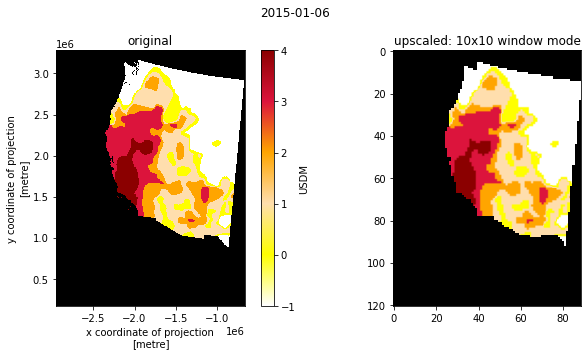

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

usdm_da.sel(time='2015-01-06').plot(vmin=-1, vmax=4, cmap=usdm_cmap(), ax=axs[0])
axs[0].set_title('original')

axs[1].imshow(reshaped[0, :, :], vmin=-1, vmax=4, cmap=usdm_cmap())
axs[1].set_title('upscaled: 10x10 window mode')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_facecolor('k')

fig.suptitle('2015-01-06')
fig.set_facecolor('w')
plt.tight_layout()

That looks pretty good!

Now onto DCVW: https://www.tandfonline.com/doi/full/10.1080/22797254.2020.1847603

First need to construct our trend surface. The article mentions settling on a quadratic, so that's what we'll do here

In [9]:
polyfit_coeff = usdm_da_windowed.polyfit(dim="time", deg=2)['polyfit_coefficients']

Now to define our function according to equations 18-20 in the paper.

In [43]:
def dcvw(win, poly):

    m = mode(win)

    ts_d0 = poly.isel(degree=0).values
    ts_d1 = poly.isel(degree=1).values
    ts_d2 = poly.isel(degree=2).values

    ts = ts_d0 + ts_d1*win + ts_d2*(win**2)

    w_numer = 1/((ts-m)**2)
    w_denom = (1/((ts-m)**2)).sum()
    w = w_numer/w_denom

    return (w*ts).sum()

Then apply like before!

In [44]:
ny = usdm_da_windowed['y_coarse']
nx = usdm_da_windowed['x_coarse']
times = usdm_da_windowed['time']

prog = tqdm(total=(len(ny)*len(nx)))

all_subs = []
#for t in times:
for yy in ny:
    for xx in nx:
        all_subs.append(
            dcvw(
                usdm_da_windowed.sel(time='2015-01-06', y_coarse=yy, x_coarse=xx).values,
                polyfit_coeff.sel(y_coarse=yy, x_coarse=xx)
            )
        )
        prog.update()

  0%|          | 0/10769 [00:00<?, ?it/s]

In [45]:
reshaped = np.reshape(np.array(all_subs), (1, 121, 89))

Now for the moment of truth ...

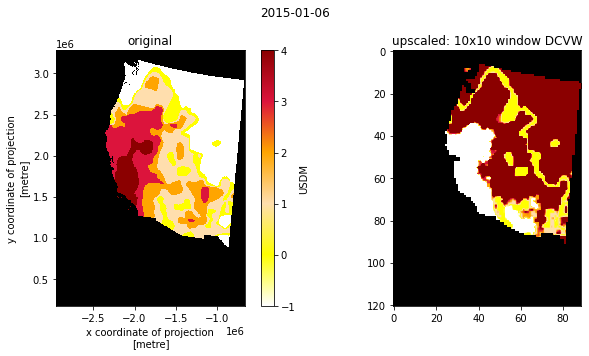

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

usdm_da.sel(time='2015-01-06').plot(vmin=-1, vmax=4, cmap=usdm_cmap(), ax=axs[0])
axs[0].set_title('original')

axs[1].imshow(reshaped[0, :, :], vmin=-1, vmax=4, cmap=usdm_cmap())
axs[1].set_title('upscaled: 10x10 window DCVW')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_facecolor('k')

fig.suptitle('2015-01-06')
fig.set_facecolor('w')
plt.tight_layout()

Huh. That's not at all what I was expecting ...